# Sistem Pencarian Dokumen menggunakan TF-IDF dan SBERT
## 1. Preprocessing Data

In [10]:
import pandas as pd
import nltk
import string
import time
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import matplotlib.pyplot as plt

# Download NLTK resources (only needed once)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

start_total = time.time()

# Load dataset
df = pd.read_csv('Data/arXiv_scientific dataset.csv')

# Use the entire dataset
dataset = df.copy().reset_index(drop=True)

# Extract title and summary columns
papers = dataset[['title', 'summary']].dropna()

# Check if category column exists (for evaluation purposes)
has_categories = 'category' in dataset.columns
if has_categories:
    papers['category'] = dataset['category']
    print(f"Dataset has {papers['category'].nunique()} unique categories")

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Text preprocessing function
def preprocess_text(text):
    """Preprocess text by lowercasing, removing punctuation, lemmatizing and removing stopwords"""
    if not isinstance(text, str):
        return ""
        
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Remove stopwords and apply lemmatization
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return " ".join(processed_tokens)

# Apply preprocessing to title and summary
papers['cleaned_title'] = papers['title'].apply(preprocess_text)
papers['cleaned_summary'] = papers['summary'].apply(preprocess_text)

# Combine title and summary for better search results
papers['combined'] = papers['cleaned_title'] + " " + papers['cleaned_summary']

# Display information about the dataset
print(f"Dataset loaded: {len(papers)} documents")
print(f"Preprocessing completed in {time.time() - start_total:.2f} seconds")
print("\nSample document:")
print(papers[['title', 'summary']].iloc[0])
print("\nAfter preprocessing (with lemmatization):")
print(papers[['cleaned_title', 'cleaned_summary']].iloc[0])

Dataset has 138 unique categories
Dataset loaded: 136238 documents
Preprocessing completed in 143.23 seconds

Sample document:
title                                   Dynamic Backtracking
summary    Because of their occasional need to return to ...
Name: 0, dtype: object

After preprocessing (with lemmatization):
cleaned_title                                   dynamic backtracking
cleaned_summary    occasional need return shallow point search tr...
Name: 0, dtype: object


## 2. Vektorisasi Dokumen
### 2.1 Vektorisasi TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Performing TF-IDF vectorization...")
# Measure TF-IDF processing time
start_time = time.time()

# Initialize TF-IDF Vectorizer with parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit features to top 5000
    stop_words='english',  # Additional stopword removal
    ngram_range=(1, 1)  # Use unigrams only
)

# Generate TF-IDF matrix from preprocessed text
tfidf_matrix = tfidf_vectorizer.fit_transform(papers['combined'])

# Record TF-IDF processing time
tfidf_time = time.time() - start_time

print(f"TF-IDF matrix shape: {tfidf_matrix.shape} (documents × features)")
print(f"TF-IDF vectorization completed in {tfidf_time:.2f} seconds")

# Get some statistics about the TF-IDF matrix
print(f"Sparsity: {100.0 * (1.0 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])):.2f}%")
print(f"Top 5 features: {list(tfidf_vectorizer.vocabulary_.keys())[:5]}")

Performing TF-IDF vectorization...
TF-IDF matrix shape: (136238, 5000) (documents × features)
TF-IDF vectorization completed in 13.39 seconds
Sparsity: 98.71%
Top 5 features: ['dynamic', 'need', 'return', 'shallow', 'point']


ImportError: Missing optional dependency 'pytables'.  Use pip or conda to install pytables.

TF-IDF (Term Frequency-Inverse Document Frequency) adalah teknik pembobotan kata yang menunjukkan pentingnya suatu kata dalam dokumen relatif terhadap koleksi dokumen. 

**Komponen TF-IDF:**
1. **Term Frequency (TF)**: Mengukur seberapa sering kata muncul dalam dokumen. Ini menunjukkan relevansi kata terhadap dokumen tersebut.
2. **Inverse Document Frequency (IDF)**: Mengukur seberapa penting kata tersebut. Kata yang muncul di banyak dokumen (seperti "dan", "atau") mendapat nilai IDF rendah.

**Keuntungan TF-IDF:**
- Mudah diimplementasikan dan diinterpretasi
- Efisien secara komputasi
- Bekerja dengan baik untuk pencarian berbasis kata kunci

**Kekurangan TF-IDF:**
- Tidak memahami semantik atau konteks
- Tidak mengenali sinonim atau kata terkait
- Tergantung pada kecocokan kata yang tepat

### 2.2 SBERT (Sentence-BERT) Embeddings

SBERT adalah model bahasa berbasis Transformer yang mengubah teks menjadi representasi vektor padat yang menangkap makna semantik. Berbeda dengan TF-IDF yang hanya menghitung frekuensi kata, SBERT memahami konteks, sinonim, dan hubungan semantik lainnya.

**Cara Kerja SBERT:**
1. Menggunakan model BERT yang telah dilatih sebelumnya untuk menghasilkan embeddings kontekstual
2. Dioptimalkan khusus untuk tugas-tugas perbandingan semantik seperti pencarian dokumen
3. Mampu menangkap hubungan semantik yang kompleks antar kata dan kalimat

**Keuntungan SBERT:**
- Pemahaman semantik yang lebih baik
- Dapat mengenali sinonim dan konsep terkait
- Bekerja dengan baik bahkan ketika kueri menggunakan terminologi yang berbeda

**Kekurangan SBERT:**
- Membutuhkan lebih banyak sumber daya komputasi
- Lebih lambat daripada metode tradisional seperti TF-IDF
- Model yang lebih kompleks untuk diimplementasikan dan dioptimalkan

In [ ]:
from sentence_transformers import SentenceTransformer

print("Generating SBERT embeddings...")
# Measure SBERT processing time
start_time = time.time()

# Load pre-trained SBERT model
sbert_model = SentenceTransformer('all-mpnet-base-v2')

# Generate document embeddings
try:
    # Using convert_to_numpy=True for compatibility with sklearn
    sbert_embeddings = sbert_model.encode(
        papers['combined'].tolist(),
        show_progress_bar=True,
        convert_to_numpy=True
    )
    sbert_success = True
except Exception as e:
    print(f"Error in SBERT encoding: {e}")
    sbert_embeddings = np.zeros((len(papers), 384))  # Default embedding size
    sbert_success = False

# Record SBERT processing time
sbert_time = time.time() - start_time

print(f"SBERT embeddings shape: {sbert_embeddings.shape} (documents × dimensions)")
print(f"SBERT encoding completed in {sbert_time:.2f} seconds")

Generating SBERT embeddings...


Batches:   0%|          | 0/4258 [00:00<?, ?it/s]

SBERT embeddings shape: (136238, 384) (documents × dimensions)
SBERT encoding completed in 3015.03 seconds


## 3. Perhitungan Similaritas
### 3.1 Cosine Similarity untuk TF-IDF

Cosine Similarity adalah metode untuk mengukur kesamaan antara dua vektor dengan menghitung cosinus sudut di antara keduanya. Nilai berkisar dari -1 (berlawanan arah) hingga 1 (arah yang sama), dengan 0 menunjukkan ketidaksamaan.

Dalam konteks pencarian dokumen, cosine similarity digunakan untuk membandingkan representasi vektor dari kueri dengan dokumen. Semakin tinggi nilai cosine similarity, semakin mirip dokumen tersebut dengan kueri.

Formula:
cos(θ) = (A·B) / (||A||·||B||)

Di mana:
- A·B adalah produk dot dari vektor A dan B
- ||A|| dan ||B|| adalah magnitudo (panjang) dari vektor A dan B

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from time import time
import numpy as np

print("Computing TF-IDF similarity matrix...")

# Use a memory-efficient approach with sampling for TF-IDF
sample_size = min(30000, tfidf_matrix.shape[0])  # Limit sample size to avoid memory issues
print(f"Using sample of {sample_size} documents for TF-IDF similarity calculation")

# Take random indices for sampling
np.random.seed(42)  # For reproducibility
sample_indices = np.random.choice(tfidf_matrix.shape[0], sample_size, replace=False)
tfidf_matrix_sample = tfidf_matrix[sample_indices]

# Calculate cosine similarity for the sampled matrix
start_time = time()
cosine_sim_tfidf = cosine_similarity(tfidf_matrix_sample)
tfidf_sim_time = time() - start_time

# Track total time
tfidf_total_time = tfidf_time + tfidf_sim_time

print(f"TF-IDF similarity matrix shape: {cosine_sim_tfidf.shape}")
print(f"Similarity calculation completed in {tfidf_sim_time:.2f} seconds")
print(f"Total TF-IDF processing time: {tfidf_total_time:.2f} seconds")

# Display sample similarity scores
print("\nSample similarity scores for document #1:")
top_5_similar = cosine_sim_tfidf[0].argsort()[-6:-1][::-1]  # Skip self
for idx in top_5_similar:
    original_idx = sample_indices[idx]
    print(f"Document #{original_idx}: {cosine_sim_tfidf[0][idx]:.4f} - '{papers['title'].iloc[original_idx][:50]}...'")

# Function to find similar documents for any document index
def find_similar_tfidf_docs(doc_index, top_k=5):
    """Find similar documents using TF-IDF vectors"""
    # Check if document is in sample
    sample_idx = np.where(sample_indices == doc_index)[0] if doc_index in sample_indices else []
    
    if len(sample_idx) > 0:
        # If in sample, use precomputed similarities
        sample_idx = sample_idx[0]
        scores = cosine_sim_tfidf[sample_idx]
        top_idxs = scores.argsort()[-top_k-1:-1][::-1]  # Exclude self
        return [(sample_indices[i], scores[i]) for i in top_idxs]
    else:
        # For documents not in sample, compute on-demand
        query_vec = tfidf_matrix[doc_index:doc_index+1]
        cos_sim = cosine_similarity(query_vec, tfidf_matrix_sample).flatten()
        top_idxs = cos_sim.argsort()[-top_k:][::-1]
        return [(sample_indices[i], cos_sim[i]) for i in top_idxs]

# Demonstrate on-demand similarity search
random_doc = np.random.choice(len(papers))
print(f"\nOn-demand TF-IDF similarity search for document #{random_doc}:")
similar_docs = find_similar_tfidf_docs(random_doc)
for idx, score in similar_docs:
    print(f"Document #{idx}: {score:.4f} - '{papers['title'].iloc[idx][:50]}...'")

Computing TF-IDF similarity matrix...
Using sample of 30000 documents for TF-IDF similarity calculation
TF-IDF similarity matrix shape: (30000, 30000)
Similarity calculation completed in 261.67 seconds
Total TF-IDF processing time: 273.45 seconds

Sample similarity scores for document #1:
Document #98276: 0.2589 - 'Insights into Performance Fitness and Error Metric...'
Document #38423: 0.2179 - 'Recent Advances on Machine Learning for Computatio...'
Document #43488: 0.2157 - 'High-Performance Distributed ML at Scale through P...'
Document #91557: 0.2067 - 'Fair Feature Importance Scores for Interpreting Tr...'
Document #47168: 0.2051 - 'Applications of physics-informed scientific machin...'

On-demand TF-IDF similarity search for document #29376:
TF-IDF similarity matrix shape: (30000, 30000)
Similarity calculation completed in 261.67 seconds
Total TF-IDF processing time: 273.45 seconds

Sample similarity scores for document #1:
Document #98276: 0.2589 - 'Insights into Performance Fitn

### 3.2 Cosine Similarity untuk SBERT

Untuk embeddings SBERT, kita juga menggunakan cosine similarity untuk mengukur kesamaan semantik antara dokumen. Meskipun metodenya sama dengan yang digunakan pada TF-IDF, hasilnya sering berbeda karena:

1. Vektor SBERT menangkap makna semantik, bukan hanya keberadaan kata
2. Embeddings SBERT lebih padat dan dimensionalitas lebih rendah dibandingkan dengan matriks TF-IDF yang sparse
3. Dokumen dengan kata-kata berbeda namun makna serupa akan memiliki nilai similaritas yang tinggi

Perhitungan cosine similarity pada embeddings SBERT memungkinkan pencarian berdasarkan makna, bukan hanya kecocokan kata kunci, sehingga sering menghasilkan hasil pencarian yang lebih relevan secara kontekstual.

In [6]:
print("Computing SBERT similarity matrix...")

if sbert_success:
    # Use the same sampling approach for SBERT to avoid memory issues
    sbert_embeddings_sample = sbert_embeddings[sample_indices]
    
    # Calculate cosine similarity for the sampled matrix
    start_time = time()
    cosine_sim_sbert = cosine_similarity(sbert_embeddings_sample)
    sbert_sim_time = time() - start_time
    
    # Total SBERT time
    sbert_total_time = sbert_time + sbert_sim_time
else:
    # Fallback if SBERT encoding failed
    cosine_sim_sbert = np.eye(len(sample_indices))
    sbert_sim_time = 0
    sbert_total_time = sbert_time
    print("Using identity matrix as fallback due to SBERT encoding failure")

print(f"SBERT similarity matrix shape: {cosine_sim_sbert.shape}")
print(f"Similarity calculation completed in {sbert_sim_time:.2f} seconds")
print(f"Total SBERT processing time: {sbert_total_time:.2f} seconds")

# Sample similarity scores for the first document
print("\nSample similarity scores for document #1:")
top_5_similar = cosine_sim_sbert[0].argsort()[-6:-1][::-1]  # Skip self
for idx in top_5_similar:
    original_idx = sample_indices[idx]
    print(f"Document #{original_idx}: {cosine_sim_sbert[0][idx]:.4f} - '{papers['title'].iloc[original_idx][:50]}...'")

# Function to find similar documents using SBERT
def find_similar_sbert_docs(doc_index, top_k=5):
    """Find similar documents using SBERT embeddings"""
    # Check if document is in sample
    sample_idx = np.where(sample_indices == doc_index)[0] if doc_index in sample_indices else []
    
    if len(sample_idx) > 0:
        # If in sample, use precomputed similarities
        sample_idx = sample_idx[0]
        scores = cosine_sim_sbert[sample_idx]
        top_idxs = scores.argsort()[-top_k-1:-1][::-1]  # Exclude self
        return [(sample_indices[i], scores[i]) for i in top_idxs]
    else:
        # For documents not in sample, compute on-demand
        query_vec = sbert_embeddings[doc_index:doc_index+1]
        cos_sim = cosine_similarity(query_vec, sbert_embeddings_sample).flatten()
        top_idxs = cos_sim.argsort()[-top_k:][::-1]
        return [(sample_indices[i], cos_sim[i]) for i in top_idxs]

# Demonstrate on-demand similarity search
print(f"\nOn-demand SBERT similarity search for document #{random_doc}:")
similar_docs = find_similar_sbert_docs(random_doc)
for idx, score in similar_docs:
    print(f"Document #{idx}: {score:.4f} - '{papers['title'].iloc[idx][:50]}...'")

# Store timing information for later comparison
model_times = {
    'TF-IDF': {
        'Processing': tfidf_time,
        'Similarity': tfidf_sim_time,
        'Total': tfidf_total_time
    },
    'SBERT': {
        'Processing': sbert_time,
        'Similarity': sbert_sim_time,
        'Total': sbert_total_time
    }
}

Computing SBERT similarity matrix...
SBERT similarity matrix shape: (30000, 30000)
Similarity calculation completed in 7.45 seconds
Total SBERT processing time: 3022.47 seconds

Sample similarity scores for document #1:
Document #92220: 0.6309 - 'What makes an image realistic?...'
Document #353: 0.5636 - 'New Millennium AI and the Convergence of History...'
Document #79111: 0.5544 - 'Efficient and Robust Machine Learning for Real-Wor...'
Document #12909: 0.5538 - 'Efficient computation of contrastive explanations...'
Document #90681: 0.5351 - 'Constructing Effective Machine Learning Models for...'

On-demand SBERT similarity search for document #29376:
Document #13001: 0.6758 - 'A Flexible Class of Dependence-aware Multi-Label L...'
Document #31406: 0.6586 - 'Does Label Differential Privacy Prevent Label Infe...'
Document #86667: 0.6474 - 'Making Classifier Chains Resilient to Class Imbala...'
Document #79612: 0.6451 - 'Adversarial Extreme Multi-label Classification...'
Document #59605

## 4. Evaluasi Performa

Untuk mengevaluasi kinerja sistem pencarian dokumen, kita menggunakan beberapa metrik standar dalam information retrieval:

1. **Precision**: Proporsi dokumen yang diambil yang relevan dengan kueri.
   - Precision = (Dokumen Relevan yang Diambil) / (Total Dokumen yang Diambil)

2. **Recall**: Proporsi dokumen relevan yang berhasil diambil dari seluruh dokumen relevan.
   - Recall = (Dokumen Relevan yang Diambil) / (Total Dokumen Relevan)

3. **Mean Average Precision (MAP)**: Rata-rata precision pada berbagai tingkat recall.

4. **Normalized Discounted Cumulative Gain (nDCG)**: Mengukur kualitas peringkat dengan memberi bobot lebih pada dokumen relevan yang muncul di peringkat atas.

5. **Runtime**: Waktu pemrosesan yang diperlukan untuk melakukan vektorisasi dan perhitungan similaritas.

Kita akan membandingkan pendekatan TF-IDF dan SBERT menggunakan metrik-metrik ini untuk menentukan metode mana yang memberikan hasil pencarian lebih baik dan lebih efisien.

In [7]:
def evaluate(sim_matrix, df, sample_indices, top_k=30):
    """
    Evaluate retrieval performance using standard metrics
    
    Args:
        sim_matrix: Similarity matrix between sampled documents
        df: DataFrame containing document information
        sample_indices: Indices of documents in the sample
        top_k: Number of top documents to consider
        
    Returns:
        Tuple of (precision, recall, mean average precision, ndcg)
    """
    precision, recall, ap, ndcg = [], [], [], []
    
    # Helper function to calculate Discounted Cumulative Gain
    def dcg(scores):
        return sum(score / np.log2(idx + 2) for idx, score in enumerate(scores))
    
    # Only evaluate if we have category information
    if 'category' not in df.columns:
        print("No category information available for evaluation")
        return 0, 0, 0, 0
    
    # Limit evaluation to a reasonable size
    eval_size = min(len(sample_indices), 1000)  # Limit to 1000 documents for speed
    eval_indices = sample_indices[:eval_size]
    
    print(f"Evaluating on {eval_size} documents...")
    
    for i, doc_idx in enumerate(range(eval_size)):
        # Get the original index in the full dataset
        original_idx = sample_indices[doc_idx]
        
        # Get true category of current document
        true_label = df.iloc[original_idx]['category']
        
        # Get similarity scores for all other documents in sample
        sim_scores = list(enumerate(sim_matrix[doc_idx]))
        
        # Sort by similarity (descending) and take top_k, excluding the document itself
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_k+1]
        
        # Map indices back to original dataset
        predicted_indices = [sample_indices[x[0]] for x in sim_scores]
        
        # Get categories of retrieved documents
        predicted_categories = df.iloc[predicted_indices]['category'].values
        
        # Relevance is 1 if category matches, 0 otherwise
        rel = [1 if label == true_label else 0 for label in predicted_categories]
        
        # Calculate precision (fraction of retrieved documents that are relevant)
        precision.append(np.mean(rel) if rel else 0)
        
        # Calculate recall (fraction of relevant documents that are retrieved)
        # We use sampled data, so this is an approximation
        relevant_in_sample = sum([1 for i in sample_indices if df.iloc[i]['category'] == true_label]) - 1
        match_count = sum(rel)
        recall.append(match_count / relevant_in_sample if relevant_in_sample > 0 else 0)
        
        # Calculate Average Precision (AP)
        if sum(rel) == 0:
            ap.append(0)
        else:
            precisions = [sum(rel[:k+1]) / (k+1) for k in range(len(rel)) if rel[k] == 1]
            ap.append(np.mean(precisions) if precisions else 0)
        
        # Calculate normalized Discounted Cumulative Gain (nDCG)
        ideal = sorted(rel, reverse=True)  # Best possible ranking
        ndcg.append(dcg(rel) / dcg(ideal) if dcg(ideal) > 0 else 0)
        
        # Show progress for long evaluations
        if eval_size > 100 and i % 100 == 0:
            print(f"  Evaluated {i}/{eval_size} documents...")
    
    # Return mean values of all metrics
    return np.mean(precision), np.mean(recall), np.mean(ap), np.mean(ndcg)

# Print timing comparison
print("\nRuntime Comparison (seconds):")
for model, times in model_times.items():
    print(f"{model}:")
    print(f"  Processing time: {times['Processing']:.2f}")
    print(f"  Similarity time: {times['Similarity']:.2f}")
    print(f"  Total time:      {times['Total']:.2f}")

# Skip evaluation if we don't have categories
if 'category' not in papers.columns:
    print("\nSkipping evaluation metrics as category information is not available.")
    # Create dummy evaluation results
    evaluation_results = {
        'TF-IDF': {'Precision': 0, 'Recall': 0, 'MAP': 0, 'nDCG': 0, 'Runtime (s)': tfidf_total_time},
        'SBERT': {'Precision': 0, 'Recall': 0, 'MAP': 0, 'nDCG': 0, 'Runtime (s)': sbert_total_time}
    }
else:
    print("\nEvaluating retrieval performance...")
    evaluation_results = {}

    # Evaluate TF-IDF performance
    print("\nEvaluating TF-IDF...")
    start_time = time()
    p_tfidf, r_tfidf, m_tfidf, n_tfidf = evaluate(cosine_sim_tfidf, papers, sample_indices, top_k=30)
    tfidf_eval_time = time() - start_time
    
    print(f"TF-IDF Evaluation results:")
    print(f"  Precision: {p_tfidf:.4f}")
    print(f"  Recall: {r_tfidf:.4f}")
    print(f"  Mean Average Precision (MAP): {m_tfidf:.4f}")
    print(f"  Normalized DCG: {n_tfidf:.4f}")
    print(f"  Evaluation time: {tfidf_eval_time:.2f} seconds")
    
    # Evaluate SBERT performance
    print("\nEvaluating SBERT...")
    start_time = time()
    p_sbert, r_sbert, m_sbert, n_sbert = evaluate(cosine_sim_sbert, papers, sample_indices, top_k=30)
    sbert_eval_time = time() - start_time
    
    print(f"SBERT Evaluation results:")
    print(f"  Precision: {p_sbert:.4f}")
    print(f"  Recall: {r_sbert:.4f}")
    print(f"  Mean Average Precision (MAP): {m_sbert:.4f}")
    print(f"  Normalized DCG: {n_sbert:.4f}")
    print(f"  Evaluation time: {sbert_eval_time:.2f} seconds")
    
    # Store evaluation results
    evaluation_results = {
        'TF-IDF': {
            'Precision': p_tfidf,
            'Recall': r_tfidf,
            'MAP': m_tfidf,
            'nDCG': n_tfidf,
            'Runtime (s)': tfidf_total_time
        },
        'SBERT': {
            'Precision': p_sbert,
            'Recall': r_sbert,
            'MAP': m_sbert,
            'nDCG': n_sbert,
            'Runtime (s)': sbert_total_time
        }
    }

# Create DataFrame for easier comparison
results_df = pd.DataFrame(evaluation_results).T

# Display results
print("\nResults Summary:")
display(results_df)


Runtime Comparison (seconds):
TF-IDF:
  Processing time: 11.79
  Similarity time: 261.67
  Total time:      273.45
SBERT:
  Processing time: 3015.03
  Similarity time: 7.45
  Total time:      3022.47

Evaluating retrieval performance...

Evaluating TF-IDF...
Evaluating on 1000 documents...
  Evaluated 0/1000 documents...
  Evaluated 0/1000 documents...
  Evaluated 100/1000 documents...
  Evaluated 100/1000 documents...
  Evaluated 200/1000 documents...
  Evaluated 200/1000 documents...
  Evaluated 300/1000 documents...
  Evaluated 300/1000 documents...
  Evaluated 400/1000 documents...
  Evaluated 400/1000 documents...
  Evaluated 500/1000 documents...
  Evaluated 500/1000 documents...
  Evaluated 600/1000 documents...
  Evaluated 600/1000 documents...
  Evaluated 700/1000 documents...
  Evaluated 700/1000 documents...
  Evaluated 800/1000 documents...
  Evaluated 800/1000 documents...
  Evaluated 900/1000 documents...
  Evaluated 900/1000 documents...
TF-IDF Evaluation results:
  Pre

,Precision,Recall,MAP,nDCG,Runtime (s)
TF-IDF,0.516833,0.005406,0.582100,0.745836,273.452598
SBERT,0.608067,0.007245,0.663287,0.799787,3022.474800


## 5. Visualisasi Performa

Pada bagian ini, kita membandingkan performa kedua metode (TF-IDF dan SBERT) secara visual menggunakan grafik. Visualisasi akan mencakup:

1. **Metrik Evaluasi**: Perbandingan precision, recall, MAP, dan nDCG antara TF-IDF dan SBERT.

2. **Waktu Pemrosesan**: Perbandingan waktu yang dibutuhkan oleh kedua metode, dibagi menjadi:
   - Waktu vektorisasi/encoding
   - Waktu perhitungan similaritas
   - Total waktu pemrosesan

Visualisasi ini membantu kita memahami trade-off antara kualitas hasil pencarian dan efisiensi komputasi untuk kedua metode.

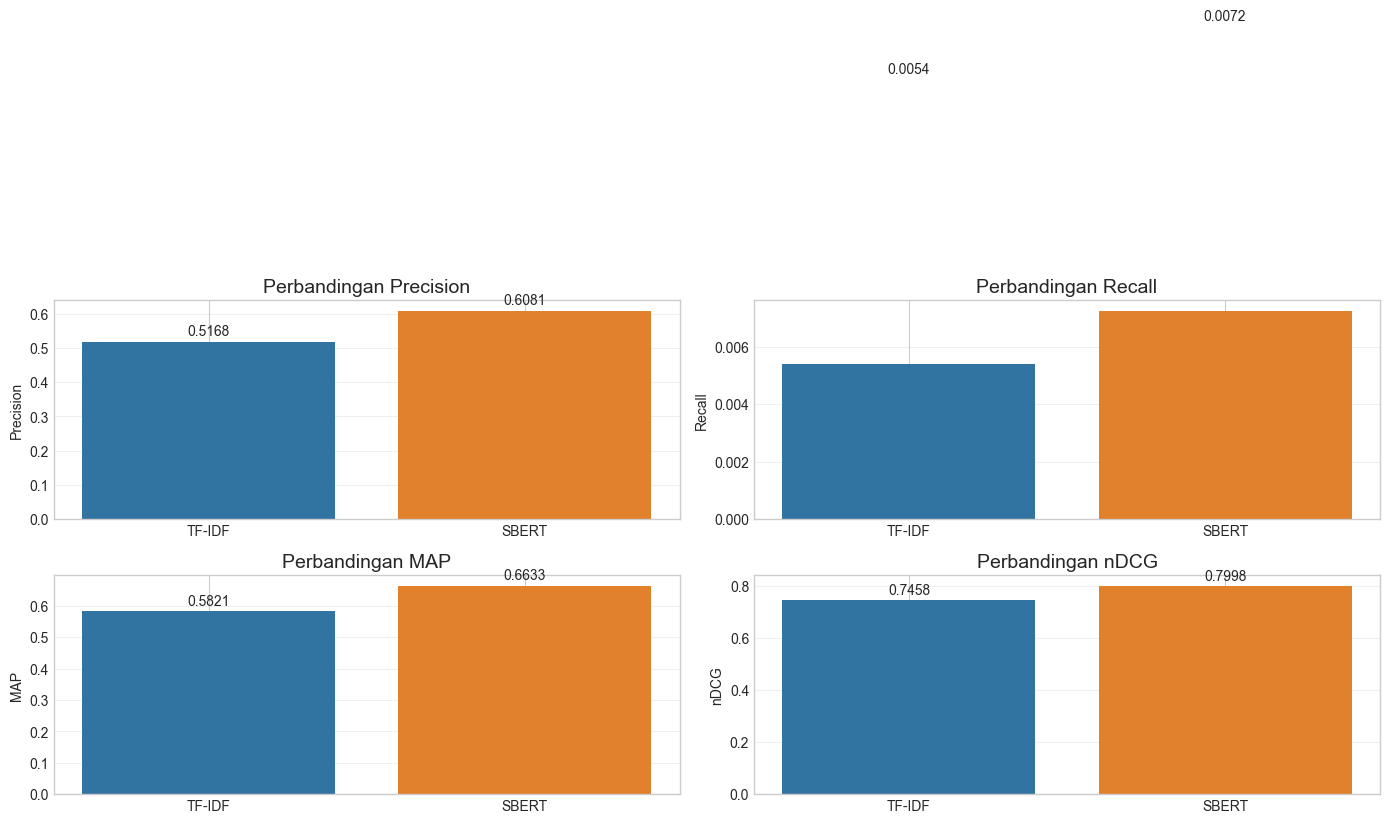

<Figure size 1200x600 with 0 Axes>

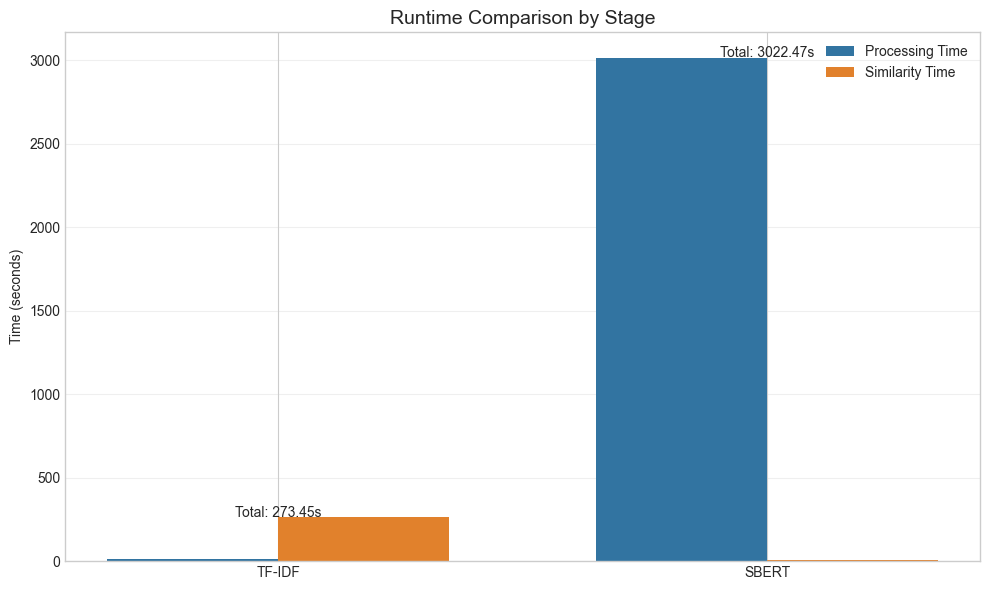

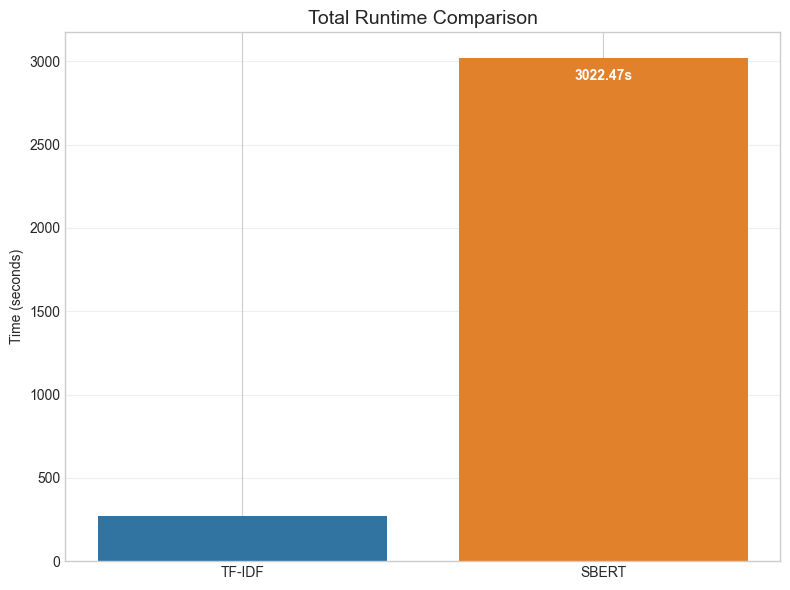

In [8]:
# Set better visual style for plots
plt.style.use('seaborn-v0_8-whitegrid')

# Create figure for comparison of evaluation metrics
metrics = ['Precision', 'Recall', 'MAP', 'nDCG']
models = list(evaluation_results.keys())

# Create subplots for metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Plot each metric
for i, metric in enumerate(metrics):
    values = [evaluation_results[model][metric] for model in models]
    
    # Create bar chart
    bars = axes[i].bar(models, values, color=['#3274A1', '#E1812C'])
    axes[i].set_title(f'Perbandingan {metric}', fontsize=14)
    axes[i].set_ylabel(metric)
    axes[i].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width()/2., 
            height + 0.01, 
            f'{height:.4f}', 
            ha='center', 
            va='bottom'
        )

plt.tight_layout()
plt.show()

# Create figure for processing time comparison
plt.figure(figsize=(12, 6))

# Prepare data for grouped bar chart
runtime_data = {
    'Processing': [model_times[model]['Processing'] for model in models],
    'Similarity': [model_times[model]['Similarity'] for model in models]
}

# Create positions for bars
x = np.arange(len(models))
width = 0.35

# Plot grouped bars
fig, ax = plt.subplots(figsize=(10, 6))
processing_bars = ax.bar(x - width/2, runtime_data['Processing'], width, 
                         label='Processing Time', color='#3274A1')
similarity_bars = ax.bar(x + width/2, runtime_data['Similarity'], width, 
                         label='Similarity Time', color='#E1812C')

# Add labels and formatting
ax.set_ylabel('Time (seconds)')
ax.set_title('Runtime Comparison by Stage', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add total time labels
for i, model in enumerate(models):
    total = model_times[model]['Total']
    ax.text(i, max(runtime_data['Processing'][i], runtime_data['Similarity'][i]) + 0.5, 
            f'Total: {total:.2f}s', ha='center')

# Show the plot
plt.tight_layout()
plt.show()

# Create a single bar chart for total runtime comparison
plt.figure(figsize=(8, 6))
total_times = [model_times[model]['Total'] for model in models]
bars = plt.bar(models, total_times, color=['#3274A1', '#E1812C'])

# Add labels and formatting
plt.title('Total Runtime Comparison', fontsize=14)
plt.ylabel('Time (seconds)')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        height * 0.95, 
        f'{height:.2f}s', 
        ha='center', 
        va='bottom',
        color='white',
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

## 6. Aplikasi Pencarian Dokumen

Aplikasi pencarian dokumen ini memungkinkan pengguna untuk mencari paper ilmiah berdasarkan kueri teks. Sistem akan memproses kueri menggunakan kedua metode (TF-IDF dan SBERT) dan menampilkan hasil pencarian berdasarkan similaritas.

Langkah-langkah pencarian:
1. Kueri pengguna di-preprocess (lowercase, hapus tanda baca, lemmatization, dll.)
2. Kueri yang sudah diproses diubah menjadi vektor menggunakan TF-IDF dan SBERT
3. Sistem menghitung similaritas antara vektor kueri dan seluruh dokumen dalam dataset
4. Dokumen dengan nilai similaritas tertinggi ditampilkan sebagai hasil pencarian

Untuk setiap dokumen hasil pencarian, sistem menampilkan:
- Judul paper
- Ringkasan (sebagian)
- Skor similaritas dengan kueri

In [9]:
# Document search function
def search_documents(query, top_k=10):
    """
    Search for documents using both TF-IDF and SBERT methods
    
    Args:
        query: Search query string
        top_k: Number of top results to return
    
    Returns:
        Dictionary with results from both methods
    """
    # Preprocess the query (including lemmatization)
    query_preprocessed = preprocess_text(query)
    print(f"Original query: '{query}'")
    print(f"Preprocessed query: '{query_preprocessed}'")
    
    results = {}
    
    # TF-IDF search
    start_time = time()
    query_vec_tfidf = tfidf_vectorizer.transform([query_preprocessed])
    
    # For searching, we can calculate similarity with all documents
    # But do it in batches to avoid memory issues
    batch_size = 10000
    all_scores_tfidf = []
    
    for i in range(0, tfidf_matrix.shape[0], batch_size):
        end = min(i + batch_size, tfidf_matrix.shape[0])
        batch = tfidf_matrix[i:end]
        batch_scores = cosine_similarity(query_vec_tfidf, batch).flatten()
        all_scores_tfidf.append(batch_scores)
    
    cos_sim_tfidf = np.concatenate(all_scores_tfidf)
    top_indices_tfidf = cos_sim_tfidf.argsort()[-top_k:][::-1]
    tfidf_search_time = time() - start_time
    
    results['TF-IDF'] = {
        'time': tfidf_search_time,
        'indices': top_indices_tfidf,
        'scores': cos_sim_tfidf[top_indices_tfidf],
        'titles': papers['title'].iloc[top_indices_tfidf].tolist(),
        'summaries': papers['summary'].iloc[top_indices_tfidf].tolist()
    }
    
    # SBERT search
    start_time = time()
    query_vec_sbert = sbert_model.encode([query], convert_to_numpy=True)
    
    # Also batch SBERT similarity calculation
    all_scores_sbert = []
    
    for i in range(0, sbert_embeddings.shape[0], batch_size):
        end = min(i + batch_size, sbert_embeddings.shape[0])
        batch = sbert_embeddings[i:end]
        batch_scores = cosine_similarity(query_vec_sbert, batch).flatten()
        all_scores_sbert.append(batch_scores)
    
    cos_sim_sbert = np.concatenate(all_scores_sbert)
    top_indices_sbert = cos_sim_sbert.argsort()[-top_k:][::-1]
    sbert_search_time = time() - start_time
    
    results['SBERT'] = {
        'time': sbert_search_time,
        'indices': top_indices_sbert,
        'scores': cos_sim_sbert[top_indices_sbert],
        'titles': papers['title'].iloc[top_indices_sbert].tolist(),
        'summaries': papers['summary'].iloc[top_indices_sbert].tolist()
    }
    
    return results

# Define query
query = "deep learning for medical diagnosis"

# Perform search
print(f"Searching for: '{query}'")
search_results = search_documents(query, top_k=5)

# Display results from both methods
for method, results in search_results.items():
    print(f"\n{'-'*80}")
    print(f"Top 5 results using {method} (found in {results['time']:.4f} seconds):")
    print(f"{'-'*80}")
    
    for i, (idx, score, title, summary) in enumerate(zip(
        results['indices'], results['scores'], results['titles'], results['summaries']
    )):
        print(f"{i+1}. [{score:.4f}] {title}")
        print(f"   {summary[:200]}...\n")

Searching for: 'deep learning for medical diagnosis'
Original query: 'deep learning for medical diagnosis'
Preprocessed query: 'deep learning medical diagnosis'

--------------------------------------------------------------------------------
Top 5 results using TF-IDF (found in 0.9652 seconds):
--------------------------------------------------------------------------------
1. [0.6302] How can Deep Learning Retrieve the Write-Missing Additional Diagnosis
  from Chinese Electronic Medical Record For DRG
   The purpose of write-missing diagnosis detection is to find diseases that
have been clearly diagnosed from medical records but are missed in the
discharge diagnosis. Unlike the definition of missed di...

2. [0.6133] Web Applicable Computer-aided Diagnosis of Glaucoma Using Deep Learning
   Glaucoma is a major eye disease, leading to vision loss in the absence of
proper medical treatment. Current diagnosis of glaucoma is performed by
ophthalmologists who are often analyzing several t

## 7. Antarmuka Pencarian Interaktif

Antarmuka pencarian interaktif memungkinkan pengguna untuk berinteraksi dengan sistem pencarian melalui komponen GUI sederhana. Pengguna dapat:

1. Memasukkan kueri pencarian dalam kotak teks
2. Memilih metode pencarian (TF-IDF, SBERT, atau keduanya)
3. Menentukan jumlah hasil yang ingin ditampilkan
4. Melihat hasil pencarian yang relevan beserta skor similaritas

In [1]:
from IPython.display import display, clear_output
import ipywidgets as widgets

# Create search interface
search_box = widgets.Text(
    value='',
    placeholder='Enter your search query here...',
    description='Search:',
    disabled=False,
    layout=widgets.Layout(width='80%')
)

results_count = widgets.Dropdown(
    options=[('5 results', 5), ('10 results', 10), ('20 results', 20)],
    value=5,
    description='Show:',
)

method_selection = widgets.RadioButtons(
    options=['TF-IDF', 'SBERT', 'Both'],
    value='Both',
    description='Method:',
    layout={'width': 'max-content'}
)

search_button = widgets.Button(
    description='Search',
    disabled=False,
    button_style='primary',
    tooltip='Click to search',
    icon='search'
)

output_area = widgets.Output()

def on_search_button_clicked(b):
    with output_area:
        clear_output()
        query = search_box.value
        
        if not query:
            print("Please enter a search query.")
            return
        
        print(f"Searching for: '{query}' using {method_selection.value}...")
        results = search_documents(query, top_k=results_count.value)
        
        if method_selection.value == 'Both':
            methods = ['TF-IDF', 'SBERT']
        else:
            methods = [method_selection.value]
        
        for method in methods:
            print(f"\n{'-'*80}")
            print(f"Top {results_count.value} results using {method} (found in {results[method]['time']:.4f} seconds):")
            print(f"{'-'*80}")
            
            for i, (score, title, summary) in enumerate(zip(
                results[method]['scores'], 
                results[method]['titles'], 
                results[method]['summaries']
            )):
                print(f"{i+1}. [{score:.4f}] {title}")
                print(f"   {summary[:200]}...\n")

search_button.on_click(on_search_button_clicked)

# Layout the widgets
search_layout = widgets.VBox([
    widgets.HBox([search_box, search_button]),
    widgets.HBox([method_selection, results_count]),
    output_area
])

# Display the interface
display(search_layout)

print("Enter a search query and click 'Search' to find relevant papers.")

Enter a search query and click 'Search' to find relevant papers.
